In [ ]:
import pandas as pd
# import numpy as np
# import keras
import sklearn
import re
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from keras import Input 

from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Dense,Embedding, Dropout,Add, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from tensorflow.keras.models import Model # type: ignore
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report
from keras.models import load_model,save_model

In [2]:
# Loading the data
df = pd.read_csv(r"C:\Users\Admin\Desktop\text.csv")#,nrows=150000
df.head(5)

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [3]:
# data analysis
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  416809 non-null  int64 
 1   text        416809 non-null  object
 2   label       416809 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 9.5+ MB
None
6
          Unnamed: 0          label
count  416809.000000  416809.000000
mean   208404.000000       1.554271
std    120322.538513       1.490453
min         0.000000       0.000000
25%    104202.000000       0.000000
50%    208404.000000       1.000000
75%    312606.000000       3.000000
max    416808.000000       5.000000


In [4]:

# Print unique topics
print(df['label'].nunique())
unique_topics = df['label'].unique()
print(unique_topics)

# Count occurrences of each unique topic
topic_counts = df['label'].value_counts()

# Print unique topics and their counts
for topic, count in topic_counts.items():
    print(f"Topic: {topic}, Count: {count}")

[4 0 2 1 5 3]
Topic: 1, Count: 141067
Topic: 0, Count: 121187
Topic: 3, Count: 57317
Topic: 4, Count: 47712
Topic: 2, Count: 34554
Topic: 5, Count: 14972


In [5]:
Emotion ={0:'sadness' ,1: 'joy', 2:'love'  ,3: 'anger' , 4:'fear' , 5:'surprise' }
for key, value in Emotion.items():
    print(f"{key}: {value}")

0: sadness
1: joy
2: love
3: anger
4: fear
5: surprise


In [6]:
# data cleaning
def data_cleaning(text):
    # Remove HTML Tags
    text = re.sub(r'<.*?>', '', text)

    # Remove Special Characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Lowercasing
    tokens = text.lower()

    # Tokenization
    tokens = word_tokenize(text)

    # Remove Numbers
    text = re.sub(r'\d+', '', ' '.join(tokens))

    # Remove Extra Whitespace
    text = ' '.join(text.split())

    return text

In [7]:
# # calling the cleaning fuction
df['text']= df['text'].apply(data_cleaning)

In [8]:
# seperating X and y
X = df['text'].values
y = df['label']

In [9]:
# train test split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=2,test_size=0.3)

In [10]:
print(y)
X_train[0]

0         4
1         0
2         4
3         0
4         4
         ..
416804    2
416805    3
416806    5
416807    3
416808    5
Name: label, Length: 416809, dtype: int64


'i don t feel confident with this so i don t commit to it and focus'

In [11]:
# tokenizer for review colomn
token = Tokenizer(lower=False,oov_token='<nothing>') 
token.fit_on_texts(X_train)
X_train = token.texts_to_sequences(X_train)
X_test = token.texts_to_sequences(X_test)  

Calculating the Parameters of the data

In [12]:
maxlen=35
# Count the number of unique topics
num_y = df['label'].nunique()
print(f"Number of unique topics: {num_y}")
# total vocab length
voc_len=len(token.word_index)+1
print(voc_len)

Number of unique topics: 6
63571


In [13]:
# for train data
X_train=pad_sequences(X_train,padding='post',maxlen=maxlen)
X_test=pad_sequences(X_test,padding='post',maxlen=maxlen)
print('Encoded X Train\n', X_train, '\n')
print('Encoded X Test\n', X_test, '\n')

Encoded X Train
 [[   2  101   43 ...    0    0    0]
 [   2   91   11 ...    0    0    0]
 [   2    3   15 ...    0    0    0]
 ...
 [   2    3   15 ...    0    0    0]
 [   2    3 2950 ...    0    0    0]
 [   2   18 4923 ...    0    0    0]] 

Encoded X Test
 [[   2  113   63 ...    0    0    0]
 [   2  237   13 ...   13 1116   52]
 [   2  841   31 ...    0    0    0]
 ...
 [   2   44    9 ...    0    0    0]
 [   2   21    8 ...  126    0    0]
 [   2    3 1402 ...    0    0    0]] 



In [14]:
# for train data
X_train=pad_sequences(X_train,padding='post',maxlen=maxlen)
X_test=pad_sequences(X_test,padding='post',maxlen=maxlen)
# print('Encoded X Train\n', X_train, '\n')
lyrics = "i went outside i am happy"

# Tokenize the lyrics
sequences = token.texts_to_sequences([lyrics])
# print(sequences)
# Pad sequences
max_len = 35  # Should match the maxlen used during training
padded_sequences = pad_sequences(sequences, padding='post', maxlen=max_len)
print(padded_sequences)

# Get the word-to-token mapping from the tokenizer
word_index = token.word_index

# Reverse the mapping (token-to-word)
reverse_word_index = {v: k for k, v in word_index.items()}

# Iterate through each token in the padded sequences and map it back to words
for sequence in padded_sequences:
    words = [reverse_word_index[token] for token in sequence if token != 0]  # Exclude padding tokens
    print("Original lyrics words:", words)

[[  2 265 734   2  24 150   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]
Original lyrics words: ['i', 'went', 'outside', 'i', 'am', 'happy']


In [15]:
print(X_train.shape)
print(X_test.shape)
type(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
print(y_train.shape)
print(y_test.shape)

(291766, 35)
(125043, 35)
(291766,)
(125043,)


TRANSFORMERS

In [16]:
def get_positional_encoding(max_len, embed_dim):
    pos = np.arange(max_len)[:, np.newaxis]
    i = np.arange(embed_dim)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
    pos_enc = pos * angle_rates
    pos_enc[:, 0::2] = np.sin(pos_enc[:, 0::2])  # apply sin to even indices in the array
    pos_enc[:, 1::2] = np.cos(pos_enc[:, 1::2])  # apply cos to odd indices in the array
    return tf.constant(pos_enc, dtype=tf.float32)

# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return Add()([x, res])

# Build the Transformer model
def build_transformer_model(vocab_size, max_len, num_classes, embed_dim=128, num_heads=8, ff_dim=1024, num_encoders=4, dropout=0.1):
    inputs = Input(shape=(max_len,))
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_len)
    x = embedding_layer(inputs)
    
    # Positional Encoding
    pos_encoding = get_positional_encoding(max_len, embed_dim)
    x += pos_encoding
    
    for _ in range(num_encoders):
        x = transformer_encoder(x, embed_dim, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs)

# Define parameters
vocab_size = voc_len  
max_len = maxlen       
num_classes = num_y    

# Build the model
model = build_transformer_model(vocab_size=vocab_size, max_len=max_len, num_classes=num_classes)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 128)      8137088     ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 35, 128)     0           ['embedding[0][0]']              
 da)                                                                                              
                                                                                                  
 layer_normalization (LayerNorm  (None, 35, 128)     256         ['tf.__operators__.add[0][0]'

In [17]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=15, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/15
2280/2280 [==============================] - 712s 310ms/step - loss: 0.7253 - accuracy: 0.7278 - val_loss: 0.2235 - val_accuracy: 0.8980
Epoch 2/15
2280/2280 [==============================] - 686s 301ms/step - loss: 0.2218 - accuracy: 0.8997 - val_loss: 0.2083 - val_accuracy: 0.9008
Epoch 3/15
2280/2280 [==============================] - 685s 301ms/step - loss: 0.2025 - accuracy: 0.9049 - val_loss: 0.2379 - val_accuracy: 0.8937
Epoch 4/15
2280/2280 [==============================] - 697s 306ms/step - loss: 0.1864 - accuracy: 0.9107 - val_loss: 0.2068 - val_accuracy: 0.9010
Epoch 5/15
2280/2280 [==============================] - 711s 312ms/step - loss: 0.1697 - accuracy: 0.9165 - val_loss: 0.1976 - val_accuracy: 0.9049
Epoch 6/15
2280/2280 [==============================] - 715s 313ms/step - loss: 0.1515 - accuracy: 0.9236 - val_loss: 0.2074 - val_accuracy: 0.9038
Epoch 7/15
2280/2280 [==============================] - 716s 314ms/step - loss: 0.1356 - accuracy: 0.9291 - val_

In [22]:
# for train data
X_train=pad_sequences(X_train,padding='post',maxlen=maxlen)
X_test=pad_sequences(X_test,padding='post',maxlen=maxlen)
# print('Encoded X Train\n', X_train, '\n')

new_lyrics = "i love you"
# Tokenize the lyrics
sequences = token.texts_to_sequences([new_lyrics])
# print(sequences)
# Pad sequences
max_len = 65  # Should match the maxlen used during training
padded_sequences = pad_sequences(sequences, padding='post', maxlen=max_len)
print(padded_sequences)


# Get the word-to-token mapping from the tokenizer
word_index = token.word_index

# Reverse the mapping (token-to-word)
reverse_word_index = {v: k for k, v in word_index.items()}

# Iterate through each token in the padded sequences and map it back to words
for sequence in padded_sequences:
    words = [reverse_word_index[token] for token in sequence if token != 0]  # Exclude padding tokens
    print("Original lyrics words:", words)

[[ 2 91 31  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
Original lyrics words: ['i', 'love', 'you']


In [28]:
# Function to predict the topic of new lyrics
def predict_topic(new_lyrics):
    # Tokenize and pad the new lyrics
    sequences = token.texts_to_sequences([new_lyrics])
    padded_sequences = pad_sequences(sequences, padding='post',maxlen=maxlen)
    
    # Predict the topic
    prediction = model.predict(padded_sequences)
    predicted_topic_index = int(np.argmax(prediction))
    # predicted_topic = label_encoder.inverse_transform([predicted_topic_index])
    print(predicted_topic_index)
    return Emotion[predicted_topic_index]  

# Example usage
new_lyrics = "i love"
predicted_topic = predict_topic(new_lyrics)
print(f"The predicted topic for the given lyrics is: {predicted_topic}")

1/1 [==============================] - 0s 34ms/step
0
The predicted topic for the given lyrics is: sadness


In [ ]:

# Assuming you have a LabelEncoder or predefined class names
class_names =   Emotion =['sadness' , 'joy', 'love'  , 'anger' , 'fear' , 'surprise']

# Evaluate the model and get predictions
y_pred = model.predict(X_test)


Accuracy: 0.9108
              precision    recall  f1-score   support

     sadness       0.94      0.95      0.95     36385
         joy       0.94      0.93      0.93     42382
        love       0.83      0.79      0.81     10404
       anger       0.91      0.91      0.91     17066
        fear       0.84      0.89      0.86     14250
    surprise       0.80      0.72      0.76      4556

    accuracy                           0.91    125043
   macro avg       0.88      0.87      0.87    125043
weighted avg       0.91      0.91      0.91    125043



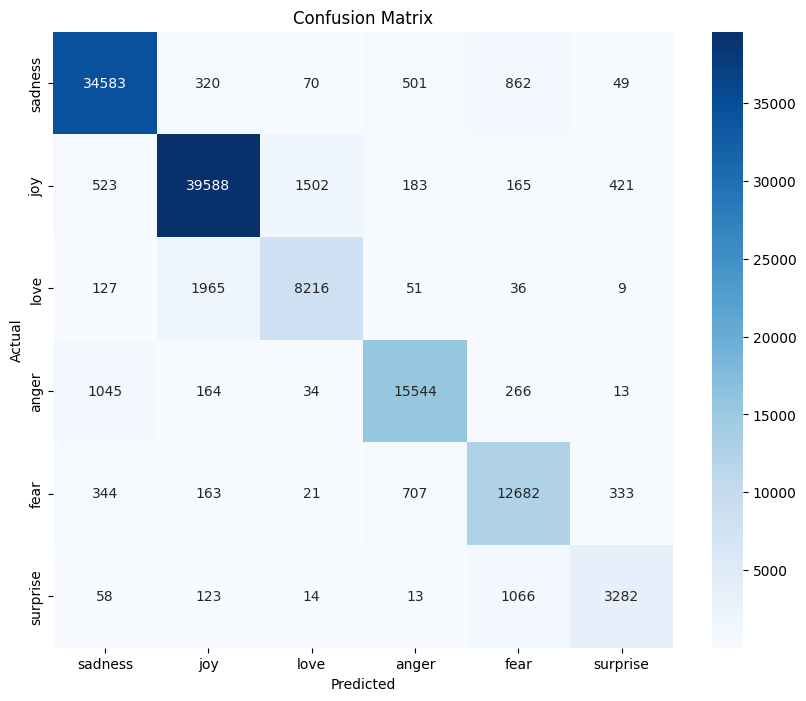

Weighted Average Precision: 0.9105
Weighted Average Recall: 0.9108
Weighted Average F1 Score: 0.9105


In [31]:
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Print classification report with class names
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix with class names
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f'Weighted Average Precision: {precision:.4f}')
print(f'Weighted Average Recall: {recall:.4f}')
print(f'Weighted Average F1 Score: {f1:.4f}')


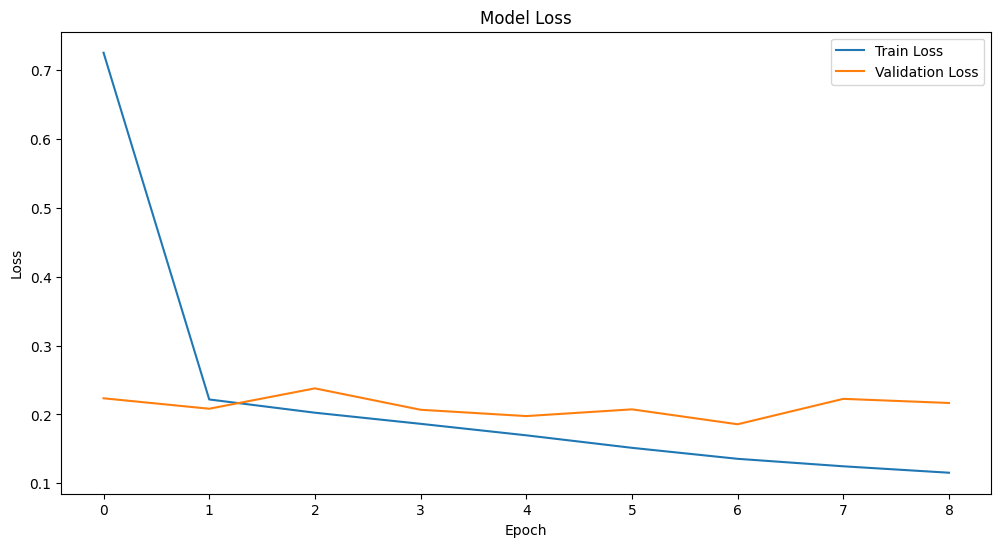

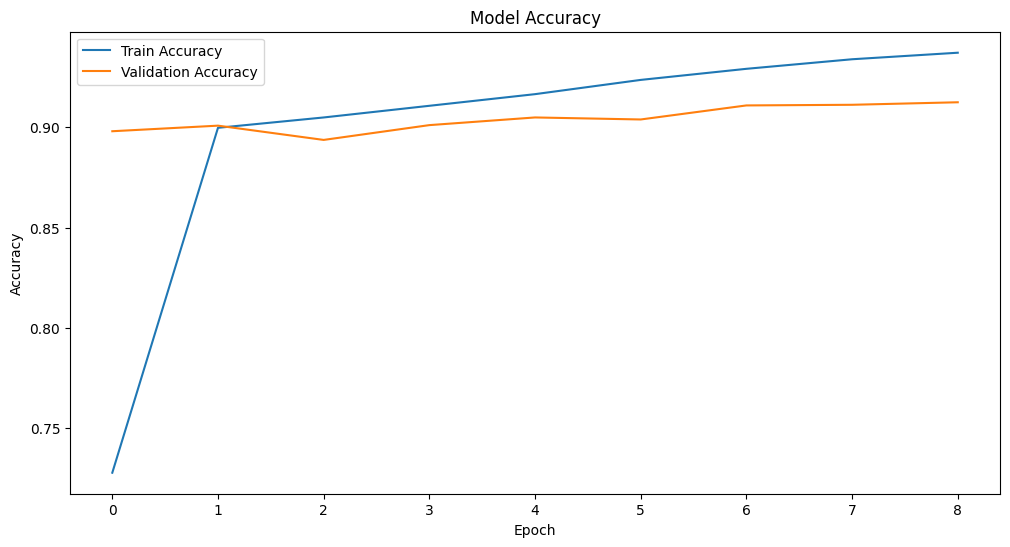

In [32]:
# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [33]:
# Function to delete a file
def delete_file(file_path):
    if os.path.exists(file_path):
        try:
            os.remove(file_path)
            print(f"File {file_path} has been deleted successfully.")
            return True
        except Exception as e:
            print(f"Error: {e}")
            return False
    else:
        print(f"File {file_path} does not exist.")
        return False

# Example usage of delete_file
model_path = "lyrics_topic_model.h5"
tokenizer_path = "tokenizer.pickle"
label_encoder_path = "label_encoder.pickle"

# Delete the model file
delete_file(model_path)

# Delete the tokenizer file
delete_file(tokenizer_path)

# Delete the label encoder file
delete_file(label_encoder_path)

File lyrics_topic_model.h5 does not exist.
File tokenizer.pickle does not exist.
File label_encoder.pickle does not exist.


False

In [34]:
# # Save the trained model to a file
# model.save('my_lstm_model.h5')

# Assume 'model', 'tokenizer', and 'label_encoder' are already defined and trained

# Save the model
save_model(model, 'lyrics_topic_model.h5')

# Save the tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(token, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # Save the label encoder
# with open('label_encoder.pickle', 'wb') as handle:
#     pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
with open('model.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: ram://da88295e-52f2-46bc-8306-e0bffb7f1cfa/assets


INFO:tensorflow:Assets written to: ram://da88295e-52f2-46bc-8306-e0bffb7f1cfa/assets


In [39]:
maxlen=maxlen

# Load the model, tokenizer, and label encoder
model = load_model('lyrics_topic_model.h5')

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# with open('label_encoder.pickle', 'rb') as handle:
#     label_encoder = pickle.load(handle)

# Function to predict the topic of new lyrics
def predict_topic(new_lyrics):
    # Tokenize and pad the new lyrics
    sequences = tokenizer.texts_to_sequences([new_lyrics])
    padded_sequences = pad_sequences(sequences, padding='post',maxlen=maxlen)
    
    # Predict the topic
    prediction = model.predict(padded_sequences) # type: ignore
    predicted_topic_index = np.argmax(prediction)
    # predicted_topic = label_encoder.inverse_transform([predicted_topic_index])
    
    return Emotion[predicted_topic_index]

# Example usage
new_lyrics = "i love you"
predicted_topic = predict_topic(new_lyrics)
print(f"The predicted topic for the given lyrics is: {predicted_topic}")



1/1 [==============================] - 1s 581ms/step
The predicted topic for the given lyrics is: sadness
